# Predicting the Presence of Heart Disease in Cleveland: <br> Determining the Effects of Age, Cholesterol, and Heart Rate

## Introduction

Heart disease, also known as cardiovascular disease, is the top leading cause of death across the world, according to the [WHO](https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death). Heart disease refers to several heart-affecting conditions, with the most common condition causing blood vessels to narrow, restricting blood flow and potentially leading to heart attack.

The predictive question we wish to answer is: <br>
***“What key factors influence the presence of heart disease, and can we accurately diagnose heart disease based on age, cholesterol levels and maximum heart rate?”***

Through data analysis, we will use the heart disease data set from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease), collected on June 30, 1988. This data set includes various observations from people in Cleveland, Hungary, Switzerland and the VA Long Beach. We will focus on the ***Cleveland data set*** to answer our question.


## Methods & Results

- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all tables and figure should have a figure/table number and a legend

To predict the presence of heart disease in patients, we will use the K-Nearest Neighbors Classification algorithm to model and classify patients. 

The labels of the Cleveland data set columns are as follows:

1. age: age
2. sex: 0 = Female, 1 = Male
3. cp: chest pain type
4. trestbps: resting blood pressure (mmHg)
5. chol: cholesterol (mg/dL)
6. fbs: fasting blood sugar (1 = high, 0 = normal)
7. restecg: resting electrocardiographic results (0 = Normal, 1 = Abnormal, 2 = Likely Damage)
8. thalach: Maximum heart rate (beats/min)
9. exang: exercise angina (1 = True, 0 = False)
10. oldpeak: ST depression by exercise
11. slope: slope of peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. ca: major vessels (#0-3)
13. thal: 3 = normal, 6 = fixed defect, 7 = reversable defect
14. num: diagnosis of heart disease

First, we will load require packages and read the `processed.cleveland.data` from the data set.

In [1]:
# Libraries/Packages to load
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# Reading the data from the web, adding column names
heart_data <- read_csv("https://raw.githubusercontent.com/Mr-Slope/DSCI-100_Group_Project/main/processed.cleveland.data",
                       col_names=c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                   "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
# Preview the data set
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In the data frame above, `ca` and `thal` are character types despite showing number values, so they should be changed to numbers. However, because R did not automatically convert, we will also use `distinct()` to see if there are hidden character values in those columns.

In [3]:
select(heart_data, ca, thal) |>
distinct()

ca,thal
<chr>,<chr>
0.0,6.0
3.0,3.0
2.0,7.0
0.0,3.0
2.0,3.0
1.0,7.0
0.0,7.0
1.0,6.0
3.0,7.0


Above, we see that there are `?` values, that must be filtered out.

In addition, we know that `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca`, `thal`, and `num` should be categorical/factor variables based on the column descriptions. It is also hard to interpret the values of these categorical variables, so we will rename them using `fct_recode()` based on the column descriptions. 

In [4]:
# Cleaning & Wrangling
heart_tidy <- heart_data |>
    filter(ca != "?", thal != "?") |>
    mutate(across(c(ca, thal), as.numeric)) |>
    mutate(across(c(sex, cp, fbs, restecg, exang, slope, ca, thal, num), as_factor)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
    mutate(cp = fct_recode(cp, "angina" = "1", "abnormal" = "2", "nonang" = "3", "asymp" = "4")) |>
    mutate(fbs = fct_recode(fbs, "high" = "1", "norm" = "0")) |>
    mutate(restecg = fct_recode(restecg, "norm" = "0", "abnorm" = "1", "damage" = "2")) |>
    mutate(exang = fct_recode(exang, "TRUE" = "1", "FALSE" = "0")) |>
    mutate(slope = fct_recode(slope, "up" = "1", "flat" = "2", "down" = "3")) |>
    mutate(thal = fct_recode(thal, "norm" = "3", "fixed" = "6", "reversible" = "7")) |>
    mutate(num = fct_recode(num, "healthy" = "0", "sick" = "1", "sick" = "2", "sick" = "3", "sick" = "4")) |> # in the data files, 1,2,3,4 are all sick
    tibble() 

# Splitting the data (separate this)
heart_split <- initial_split(heart_tidy, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

head(heart_training)

# Summary Statistics
heart_min_max <- heart_training |>
    select(age, trestbps, chol, thalach, oldpeak, num) |>    
    group_by(num) |>
    summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
              min_trestbps = min(trestbps), max_trestbps = max(trestbps),
              min_chol = min(chol), max_chol = max(chol), 
              min_thalach = min(thalach), max_thalach = max(thalach),
              min_oldpeak = min(oldpeak), max_oldpeak = max(oldpeak),
              count = n())

heart_summary_sex <- heart_training |>
    group_by(sex) |>
    summarize(count = n())

heart_min_max
heart_summary_sex

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,male,angina,145,233,high,damage,150,FALSE,2.3,down,0,fixed,healthy
41,female,abnormal,130,204,norm,damage,172,FALSE,1.4,up,0,norm,healthy
56,male,abnormal,120,236,norm,norm,178,FALSE,0.8,up,0,norm,healthy
57,male,asymp,140,192,norm,norm,148,FALSE,0.4,flat,0,fixed,healthy
44,male,abnormal,120,263,norm,norm,173,FALSE,0.0,up,0,reversible,healthy
52,male,nonang,172,199,high,norm,162,FALSE,0.5,up,0,reversible,healthy


num,min_age,max_age,mean_age,min_trestbps,max_trestbps,min_chol,max_chol,min_thalach,max_thalach,min_oldpeak,max_oldpeak,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
healthy,29,74,52.18333,94,180,126,564,96,202,0,4.2,120
sick,40,77,57.50980,100,200,149,409,71,177,0,4.4,102


sex,count
<fct>,<int>
female,68
male,154


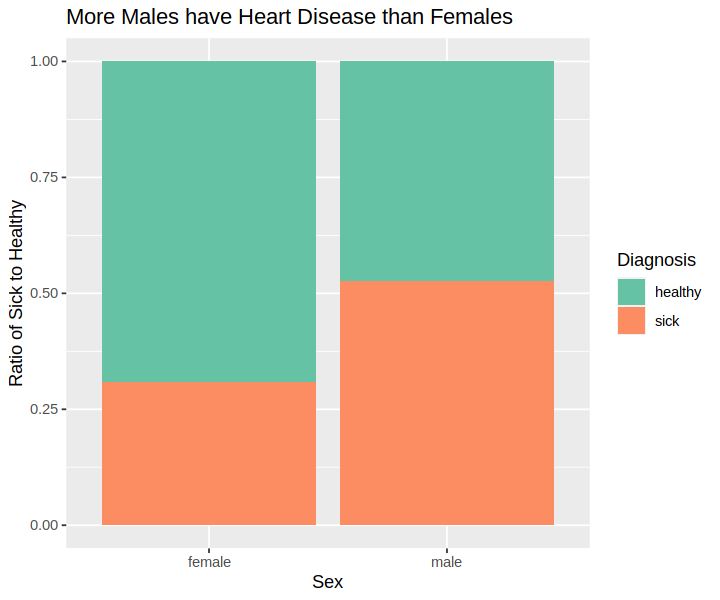

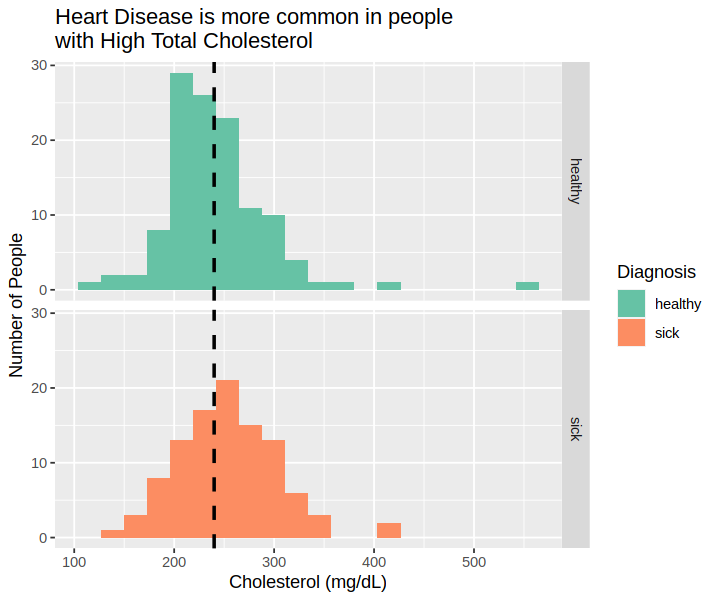

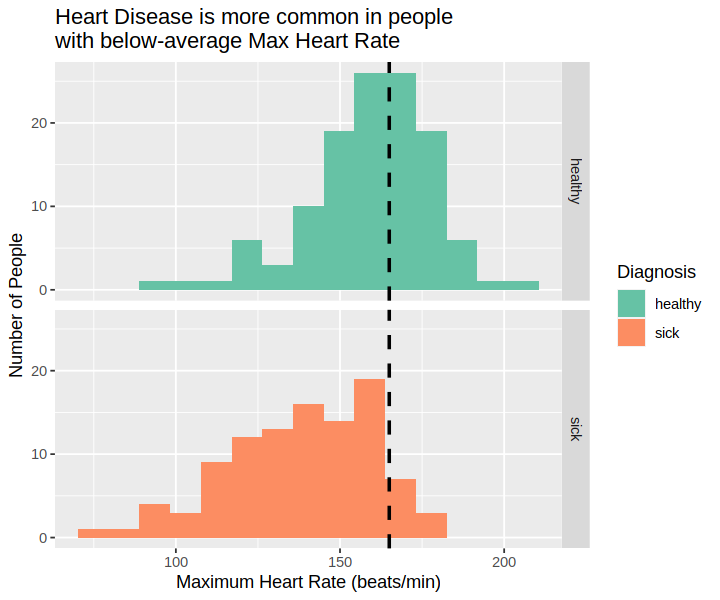

In [5]:
# Visualizations of Key Predictor Variables
options(repr.plot.width = 6, repr.plot.height = 5)

# Male to Female ratios b/w Sick & Healthy (Age)
male_female <- heart_training |>
    ggplot(aes(x=sex,fill=num)) +
    geom_bar(position="fill") +
    labs(x="Sex", y="Ratio of Sick to Healthy", fill="Diagnosis",
         title="More Males have Heart Disease than Females") +
    scale_fill_brewer(palette = "Set2")
male_female

# Dangerous Total Cholesterol is 240 mg/dL and above for adults 20 years old and over
# Higher cholesterol may lead to higher risk
chol_histogram <- heart_training |>
    ggplot(aes(x = chol, fill=num)) +
    geom_histogram(bins=20) +
    facet_grid(rows = vars(num)) +
    geom_vline(xintercept = 240, linetype = "dashed", linewidth = 1.0) +
    labs(x="Cholesterol (mg/dL)", fill="Diagnosis", y="Number of People",
        title="Heart Disease is more common in people \nwith High Total Cholesterol") +
    scale_fill_brewer(palette = "Set2")
chol_histogram

# Average Max heart rate for the mean age of 55 is 165 beats per min
# Below-average Max Heart Rate signifies poor circulation, increasing risk
trestbps_histogram <- heart_training |>
    ggplot(aes(x = thalach, fill=num)) +
    geom_histogram(bins=15) +
    facet_grid(rows = vars(num)) +
    geom_vline(xintercept = 165, linetype = "dashed", linewidth = 1.0) +
    labs(x="Maximum Heart Rate (beats/min)", fill="Diagnosis", y="Number of People",
         title="Heart Disease is more common in people \nwith below-average Max Heart Rate") +
    scale_fill_brewer(palette = "Set2")
trestbps_histogram

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References



Creators of the heart data base are:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.
